# Learning State
This notebook deals with learning the state of a device from the current information at each point in the voltage space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
import glob

## Loading the data
[Change the data path when loading from a different folder]

In [2]:
data_path = "/Users/sandesh/data/quantum-ml/data_for_paper/double_dot_low_var/"
files = glob.glob(data_path + "*.npy")
print(len(files))

1060


### Sample Data

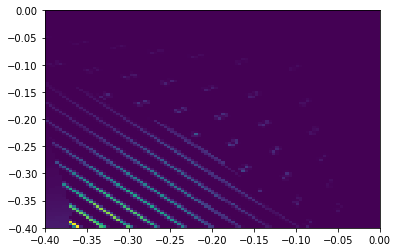

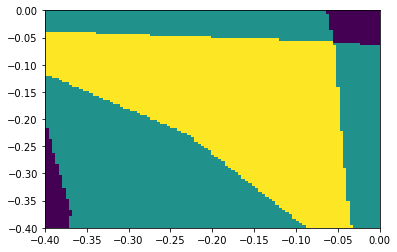

In [3]:
import random
sample_data = np.load(random.choice(files)).item()

V_P1_vec = sample_data['V_P1_vec']
V_P2_vec = sample_data['V_P2_vec']
N_v = len(V_P1_vec)
current = np.array([x['current'] for x in sample_data['output']]).reshape(N_v,N_v)
state = np.array([x['state'] for x in sample_data['output']]).reshape(N_v,N_v)

XX,YY = np.meshgrid(V_P1_vec,V_P2_vec)
plt.figure(1)
plt.pcolor(XX,YY,1e6*current)
plt.figure(2)
plt.pcolor(XX,YY,state)

### Load the entire dataset
The current and the state maps will be loaded in a single array.

In [4]:
inp_array = []
out_array = []
for file in files[:]:
    dat = np.load(file).item() 
    inp_array.append(np.array([x['current'] for x in dat['output']]))
    out_array.append(np.array([x['state'] for x in dat['output']]))
inp_array = np.array(inp_array)
out_array = np.array(out_array)

## Define CNN 

The CNN takes in the current information as the input and provides the state information as the output.

In [20]:
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

# application logic will be added here
def cnn_model_fn(features,labels,mode):
    '''Model function for CNN'''
    #input layer
    input_layer = tf.cast(tf.reshape(features["x"],[-1,10000]),tf.float32)
    
    #conv1 = tf.layers.conv2d(inputs=input_layer,
    #                        filters=8,
    #                        kernel_size=[5,5],
    #                        padding="same",
    #                        activation=tf.nn.relu)
    #pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2],strides=2)
    #
    #conv2 = tf.layers.conv2d(inputs=pool1,
    #                        filters=16,
    #                        kernel_size=[5,5],
    #                        padding="same",
    #                        activation=tf.nn.relu)
    #pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2],strides=2)
    #
    #flat = tf.contrib.layers.flatten(inputs=pool2)
    # dense output layer
    out1 = tf.layers.dense(inputs=input_layer,units=2048,activation=tf.nn.relu)  
    out2 = tf.layers.dense(inputs=out1,units=1024,activation=tf.nn.relu)  
    out3 = tf.layers.dense(inputs=out2,units=512,activation=tf.nn.relu)  
    out4 = tf.layers.dense(inputs=out3,units=256,activation=tf.nn.relu)  
    
    out = tf.layers.dense(inputs=out4, units=10000)
    
    loss = None

    # Calculate loss( for both TRAIN AND EVAL modes)
    if mode != learn.ModeKeys.INFER:
        loss = tf.losses.mean_squared_error(labels=labels, predictions=out)

    # Configure the training op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # Generate predictions
    predictions= {
        "states" : tf.rint(out),
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)


    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["states"])}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


## Divide the dataset into training and test data

In [18]:
# determines the number of inputs used as the training set
# the rest are treated as a test set
train_factor = 0.9

n_tot = inp_array.shape[0]
n_train = int(train_factor*n_tot)
n_test = n_tot - n_train

# input parameters
n_inp = inp_array[0].shape[0] 
n_out = out_array[0].shape[0] 
print("Number of inputs:", n_inp)
print("Number of outputs:", n_out)

x_train_data = inp_array[:n_train]
y_train_data = out_array[:n_train].astype(int)
x_test_data = inp_array[n_train:]
y_test_data = out_array[n_train:].astype(int)

print("Total, Training, Test")
print(n_tot, n_train, n_test)

Number of inputs: 10000
Number of outputs: 10000
Total, Training, Test
1060 954 106


## Define the input  functions

In [21]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : x_train_data},
      y=y_train_data,
      num_epochs=100,
      batch_size=32,
      shuffle=False)
test_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x" : x_test_data},
      y=y_test_data,
      shuffle=False)




## Train the CNN

In [27]:
state_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
state_classifier.train(input_fn=train_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_task_id': 0, '_session_config': None, '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_is_chief': True, '_task_type': 'worker', '_num_ps_replicas': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x116997d68>, '_model_dir': '/var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpf30mtpja', '_service': None, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_save_checkpoints_steps': None, '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpf30mtpja/model.ckpt.
INFO:tensorflow:loss = 2.01038, step = 1
INFO:tensorflow:global_step/sec: 2.26434
INFO:tensorflow:loss = 0.18165, step = 101 (44.217 sec)
INFO:tensorflow:global_step/sec: 2.6914
INFO:tensorflow:loss = 0.194083, step =

More training, if necessary.

In [35]:
state_classifier.train(input_fn=train_input_fn)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpf30mtpja/model.ckpt-5964
INFO:tensorflow:Saving checkpoints for 5965 into /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpf30mtpja/model.ckpt.
INFO:tensorflow:loss = 0.0539478, step = 5965
INFO:tensorflow:global_step/sec: 2.78824
INFO:tensorflow:loss = 0.0561397, step = 6065 (35.876 sec)
INFO:tensorflow:global_step/sec: 3.00906
INFO:tensorflow:loss = 0.0597253, step = 6165 (33.231 sec)
INFO:tensorflow:global_step/sec: 3.17123
INFO:tensorflow:loss = 0.0682459, step = 6265 (31.532 sec)
INFO:tensorflow:global_step/sec: 3.03409
INFO:tensorflow:loss = 0.063166, step = 6365 (32.967 sec)
INFO:tensorflow:global_step/sec: 2.33942
INFO:tensorflow:loss = 0.0552397, step = 6465 (42.741 sec)
INFO:tensorflow:global_step/sec: 2.82826
INFO:tensorflow:loss = 0.054085, step = 6565 (35.353 sec)
INFO:tensorflow:global_step/sec: 3.30686
INFO:tensorflow:loss = 0.06012

## Evaluate the Model

In [36]:
eval_results = state_classifier.evaluate(input_fn=test_input_fn,steps=1)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2017-12-11-11:56:27
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpf30mtpja/model.ckpt-8946
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-11-11:56:29
INFO:tensorflow:Saving dict for global step 8946: accuracy = 0.896676, global_step = 8946, loss = 0.0816705
{'loss': 0.081670485, 'accuracy': 0.89667642, 'global_step': 8946}


In [37]:
predictions = list(state_classifier.predict(input_fn = test_input_fn))

INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmpf30mtpja/model.ckpt-8946


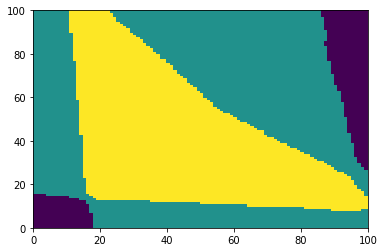

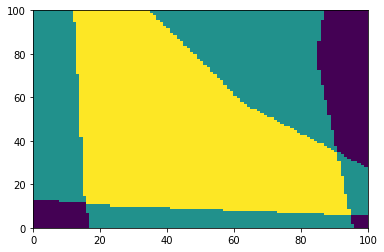

In [38]:
index = np.random.randint(len(predictions))
plt.figure(1)
plt.pcolor(predictions[index]['states'].reshape(100,100))
plt.figure(2)
plt.pcolor(y_test_data[index].reshape(100,100))